# Estimating hotspot(s) emission using NeRF. 

Notes:
Inner most stable circular orbit (ISCO), for spin=0 with r_g=2 this is at 3M \
Overleaf notes: https://www.overleaf.com/project/60ff0ece5aa4f90d07f2a417

In [1]:
import sys
sys.path.append('../bhnerf')

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import xarray as xr
import flax
from flax.training import train_state
import optax

import jax
from jax import random
from jax import numpy as jnp

import numpy as np
import matplotlib.pyplot as plt

import utils, emission_utils, visualization, network_utils
from network_utils import shard
import mediapy

from tensorboardX import SummaryWriter
from datetime import datetime
from tqdm.notebook import tqdm
import ipyvolume as ipv
from ipywidgets import interact
import ipywidgets as widgets

%load_ext autoreload
%autoreload 2

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-6e0b69l1 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def plot_measurements(measurements, extent=[0,1,0,1], figsize=(7,7)):
    plt.style.use('default')
    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.imshow(measurements, origin='lower', extent=extent)
    ax.set_xlabel('pix')
    ax.set_ylabel('t')
    
def plot_emission(emission, extent=[0,1,0,1], figsize=(7,7)):
    plt.style.use('default')
    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.imshow(emission, origin='lower', extent=extent)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

def train_network(sensor, emission, emission_test, velocity_field, hparams, runname, log_period=100, y_res_vis=64, x_res_vis=64):
    
    # Training / testing coordinates
    train_coords = network_utils.get_input_coords(sensor, nt=emission.t.size)
    t, x, y, z, d = train_coords.values()
    train_radiance = measurements.data.ravel() 

    test_coords = network_utils.get_input_coords(sensor, nt=emission_test.t.size)
    test_radiance = measurements_test.data.ravel() 
    t_test, x_test, y_test, z_test, d_test = test_coords.values()

    # Emission visualization inputs
    t_res_vis = 1
    emission_extent = [emission.x[0], emission.x[-1], emission.y[0], emission.y[-1]]
    t_vis, y_vis, x_vis = np.meshgrid(0.0, np.linspace(emission_extent[2], emission_extent[3], y_res_vis),
                                      np.linspace(emission_extent[0], emission_extent[1], x_res_vis),
                                      indexing='ij')
    
    d_vis = np.ones_like(y_vis)                  # meaningless placeholder for emission visualization
    target_vis = np.ones([y_res_vis, x_res_vis]) # meaningless placeholder for emission visualization
    r_min = sensor.r.min().data                  # Zero network output where there is no supervision (within black-hole radius)  

    # Model setup and initialization
    rng = jax.random.PRNGKey(1)
    predictor = network_utils.PREDICT_EMISSION_2D(posenc_deg=hparams['posenc_deg'])
    params = predictor.init(rng, x[:1, ...], y[:1, ...], t[:1, ...], velocity_field)['params']
    tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
    state = train_state.TrainState.create(apply_fn=predictor.apply, params=params.unfreeze(), tx=tx)  # TODO(pratul): this unfreeze feels sketchy

    train_pstep = jax.pmap(predictor.train_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, 0), static_broadcasted_argnums=(0))
    eval_pstep = jax.pmap(predictor.eval_step, axis_name='batch', in_axes=(None, None, 0, 0, 0, 0, 0, 0, 0), static_broadcasted_argnums=(0))
    rand_key = jax.random.split(rng, jax.local_device_count())
    state = flax.jax_utils.replicate(state)

    # TensorBoard logging
    time = datetime.now().strftime('%Y-%m-%d.%H:%M:%S')
    logdir = 'runs/{}.{}'.format(runname, time)
    with SummaryWriter(logdir=logdir) as writer:
        
        # Log ground-truth data   
        %matplotlib inline
        plot_emission(emission.isel(t=0), emission_extent)
        writer.add_figure('emission/true', plt.gcf(), global_step=0)
        plot_measurements(measurements)
        writer.add_figure('measurements/true', plt.gcf(), global_step=0)

        for i in tqdm(range(1, hparams['num_iters']+1), desc='iteration'):

            # Testing and Visualization
            if (i == 1) or (i % log_period) == 0:
                
                loss_test, _, emission_pred_test, rendering_test, _ = eval_pstep(
                    velocity_field, i, shard(x_test), shard(y_test), shard(d_test), shard(t_test), shard(test_radiance), state, rand_key
                )
                rendering_test = np.reshape(rendering_test, [emission_test.t.size, sensor.pix.size])
                writer.add_scalar('log loss/test', np.log10(np.mean(float(loss_test))), global_step=i)

                _, _, emission_vis, _, _ = eval_pstep(
                    velocity_field, i, shard(x_vis), shard(y_vis), shard(d_vis), shard(t_vis), shard(target_vis), state, rand_key
                )
                emission_vis = np.reshape(emission_vis, [t_res_vis, y_res_vis, x_res_vis])
                emission_vis = jnp.where(x_vis**2 + y_vis**2 >= r_min**2, emission_vis, jnp.zeros_like(emission_vis))

                # Log prediction and estimate
                plot_emission(emission_vis[0], emission_extent)
                writer.add_figure('emission/esimate', plt.gcf(), global_step=i)
                plot_measurements(rendering_test)
                writer.add_figure('measurements/prediction', plt.gcf(), global_step=i)

            # Training
            batch_inds = np.random.randint(0, x.shape[0], hparams['batchsize'])
            loss_train, state, _, _, rand_key = train_pstep(
                velocity_field, i, 
                shard(x[batch_inds, ...]), shard(y[batch_inds, ...]), 
                shard(d[batch_inds, ...]), shard(t[batch_inds, ...]), 
                shard(train_radiance[batch_inds, ...]), 
                state, rand_key
            )
            writer.add_scalar('log loss/train', np.log10(float(np.mean(loss_train))), global_step=i)
            
        return state, emission_vis

In [32]:
# Load sensor and pre-processes
sensor = xr.load_dataset('../sensors/a0.00_th1.57_ngeo200_npix10000.nc')
# remove ray samples outside of the domain 
sensor = sensor.where(sensor.r < 5)    

In [22]:
# Generate hotspot emission
nt, nx, ny, nz = 64, 64, 64, 64
nt_test = 64
nspots = 1
r_isco = 3.0 

phi = np.deg2rad(0)      # azimuth angle (ccw from x-axis)
theta = np.pi / 4.       # zenith angle (pi/2 = equatorial plane)

orbit_radius = 3.5 
std = .4 * np.ones_like(orbit_radius)
initial_frame = emission_utils.generate_hotspots_3d(nx, ny, nz, theta, phi, orbit_radius, std, r_isco)

orbit_period = 3.5**(-3./2.) 
velocity_field = lambda r: (1.0 / orbit_period) * r**(-3/2)

rot_axis =  np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)])
emission = emission_utils.generate_orbit_3d(initial_frame, nt, velocity_field, rot_axis)
emission_test = emission_utils.generate_orbit_3d(initial_frame, nt_test, velocity_field, rot_axis)

In [24]:
extent = [(float(initial_frame[dim].min()), float(initial_frame[dim].max())) for dim in initial_frame.dims]
@interact(t=widgets.IntSlider(min=0, max=emission.t.size-1, step=1, value=0))
def plot_vol(t):
    ipv.figure()
    ipv.view(0, -60, distance=2.5)
    ipv.volshow(emission.isel(t=t), extent=extent, memorder='F', level=[0, 0.2, 0.7], opacity=[0, 0.2, 0.3], controls=False)
    ipv.show()

interactive(children=(IntSlider(value=0, description='t', max=63), Output()), _dom_classes=('widget-interact',…

In [33]:
# Generate radiance measurements 
measurements = emission_utils.integrate_rays(emission, sensor)
measurements_test = emission_utils.integrate_rays(emission_test, sensor)

In [37]:
measurements_movie = xr.DataArray(measurements.data.reshape(nt, sensor.num_alpha, sensor.num_beta), dims=['t', 'alpha', 'beta'])

%matplotlib widget
measurements_movie.utils_visualization.animate()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
# Training parameters
hparams = {
    'num_iters': 10000,
    'lr_init': 1e-4,
    'lr_final': 1e-6,
    'posenc_deg': 3
}
state, emission_vis = train_network(
    sensor, emission, emission_test, velocity_field, hparams, 
    runname='orbiting_hs', log_period=100, y_res_vis=128, x_res_vis=128
)

/home/alevis/.conda/envs/bhnerf/lib/python3.7/site-packages/jax/lib/xla_bridge.py:391: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/home/alevis/.conda/envs/bhnerf/lib/python3.7/site-packages/jax/lib/xla_bridge.py:378: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "


iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

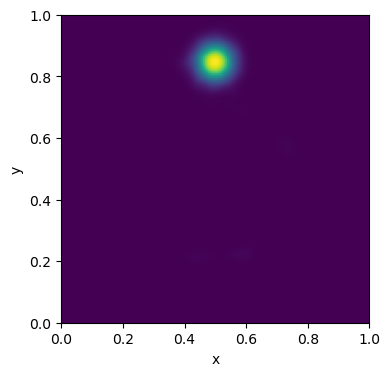

In [14]:
plot_emission(emission_vis[0], figsize=(4,4))